In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import torch 
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from dataset import get_data
from model import Net

import numpy as np
from sklearn.metrics import fbeta_score

In [5]:
train_dl, val_dl = get_data()
model = Net([16, 32, 64], 17)

In [6]:
EPOCHS = 2
LR = 5e-2
BS = train_dl.batch_size
BATCHES = len(train_dl)
PRINT = 20

In [7]:
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=LR)

In [8]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = model.to(device)

In [9]:
def f2_score(output, target, threshold=0.5):
    target, output = target.cpu().numpy(), output.detach().cpu().numpy()
    output = output > 0.3
    return fbeta_score(target, output, beta=2, average='samples')

In [10]:
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []

for epoch in range(1, EPOCHS + 1):
    model.train()
    for idx, (data, target) in enumerate(train_dl, 1):
        data, target = data.to(device), target.to(device)
        
        output = model(data)
        loss = criterion(output, target)
        accuracy = f2_score(output, target) 
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        if idx % PRINT == 0:
            print(f'Epoch: {epoch}: [{idx*BS}/{BS*BATCHES}] {int((idx*BS)/(BS*BATCHES)*100)}% Loss: {loss.item():.2f} Accuracy: {accuracy:.2f}')
        
    model.eval()
    with torch.no_grad():
        val_loss = 0.
        for idx, (data, target) in enumerate(val_dl):
            data, target = data.to(device), target.to(device)
            output = model(data)
            val_loss += criterion(output, target)
            accuracy = f2_score(output, target)
        print(f'Val Loss: {val_loss.item()/BS*len(val_dl):.2f} Accuracy: {accuracy:.2f}')

Epoch: 1: [200/2000] 10% Loss: 0.67 Accuracy: 0.51
Epoch: 1: [400/2000] 20% Loss: 0.66 Accuracy: 0.46
Epoch: 1: [600/2000] 30% Loss: 0.65 Accuracy: 0.47
Epoch: 1: [800/2000] 40% Loss: 0.62 Accuracy: 0.47
Epoch: 1: [1000/2000] 50% Loss: 0.61 Accuracy: 0.45
Epoch: 1: [1200/2000] 60% Loss: 0.64 Accuracy: 0.56
Epoch: 1: [1400/2000] 70% Loss: 0.61 Accuracy: 0.52
Epoch: 1: [1600/2000] 80% Loss: 0.60 Accuracy: 0.55
Epoch: 1: [1800/2000] 90% Loss: 0.59 Accuracy: 0.51
Epoch: 1: [2000/2000] 100% Loss: 0.55 Accuracy: 0.48
Val Loss: 1.42 Accuracy: 0.53
Epoch: 2: [200/2000] 10% Loss: 0.53 Accuracy: 0.52
Epoch: 2: [400/2000] 20% Loss: 0.54 Accuracy: 0.52
Epoch: 2: [600/2000] 30% Loss: 0.51 Accuracy: 0.45
Epoch: 2: [800/2000] 40% Loss: 0.50 Accuracy: 0.50
Epoch: 2: [1000/2000] 50% Loss: 0.49 Accuracy: 0.46
Epoch: 2: [1200/2000] 60% Loss: 0.47 Accuracy: 0.54
Epoch: 2: [1400/2000] 70% Loss: 0.45 Accuracy: 0.50
Epoch: 2: [1600/2000] 80% Loss: 0.44 Accuracy: 0.61
Epoch: 2: [1800/2000] 90% Loss: 0.44 Accu

In [14]:
msd = model.state_dict()
for name, tensor in msd.items():
    print(name, tensor.shape)

conv1.weight torch.Size([16, 3, 5, 5])
conv1.bias torch.Size([16])
layers.0.conv.weight torch.Size([32, 16, 3, 3])
layers.0.conv.bias torch.Size([32])
layers.0.bn.weight torch.Size([32])
layers.0.bn.bias torch.Size([32])
layers.0.bn.running_mean torch.Size([32])
layers.0.bn.running_var torch.Size([32])
layers.0.bn.num_batches_tracked torch.Size([])
layers.1.conv.weight torch.Size([64, 32, 3, 3])
layers.1.conv.bias torch.Size([64])
layers.1.bn.weight torch.Size([64])
layers.1.bn.bias torch.Size([64])
layers.1.bn.running_mean torch.Size([64])
layers.1.bn.running_var torch.Size([64])
layers.1.bn.num_batches_tracked torch.Size([])
linear.weight torch.Size([17, 64])
linear.bias torch.Size([17])


In [15]:
osd = optimizer.state_dict()
osd

{'state': {},
 'param_groups': [{'lr': 0.05,
   'momentum': 0,
   'dampening': 0,
   'weight_decay': 0,
   'nesterov': False,
   'params': [140334376741264,
    140334361509104,
    140334361509032,
    140334361508240,
    140334362312424,
    140334362312496,
    140334372081808,
    140334372081880,
    140334372081952,
    140334372082024,
    140334372082312,
    140334372082384]}]}

In [11]:
sample, target = next(iter(val_dl))

In [12]:
sample.shape, target.shape

(torch.Size([20, 3, 64, 64]), torch.Size([20, 17]))

In [13]:
img = sample[1]
classes = target[1]

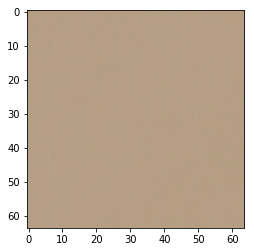

In [14]:
import matplotlib.pyplot as plt
plt.imshow(img.permute(1,2,0).numpy())

In [15]:
orig = list(zip(val_dl.dataset.mlb.classes_, classes))

In [16]:
output = model(img.unsqueeze_(dim=0).to(device))

In [17]:
pred = list(zip(val_dl.dataset.mlb.classes_, (output > 0.5).squeeze().cpu().numpy()))

In [18]:
orig = [(name, score) for (name, score) in orig if score.cpu().item() == 1.0]
pred = [(name, score) for (name, score) in pred if score == 1.0]

In [19]:
pred, orig

([('agriculture', 1), ('primary', 1), ('road', 1)],
 [('clear', tensor(1.)), ('primary', tensor(1.)), ('water', tensor(1.))])